# Демодуляция. 
# Часть 2. Double Sideband Suppressed Carrier 
# (AM-DSB-SC)

## 1. Когерентная демодуляция с помощью возведения сигнала в квадрат

Для качественного приема АМ-сигналов когерентным способом необходимо точное совпадение частоты и фазы несущей и генератора в приемнике. Чтобы этого добиться, для сигнала с подавленной несущей нужно использовать специальную систему фазовой автоподстройки частоты, которая выполняет возведение принимаемого сигнала в квадрат. Схема приемного устройства имеет вид:

<img src="../../images/DSB_SC_Receiver_2_1.png" width=500/>

В отличие от классической PLL, которая состоит из фазового детектора, петлевого фильтра и управляемого генератора, в данной PLL присутствует еще несколько узлов. Схема представлена ниже: 

<img src="../../images/DSB_SC_Receiver_2_2.png" width=500/>

Блок Square выполняет возведение сигнала в квадват. Далее результат фильтруется блоком Filter и подается на фазовый детектор обычной PLL. Внутри схемы присутствует дополнительный управляемый генератор, на вход которого подается уменьшенный вдвое сигнал от петлевого фильтра. Выход этого генератора является выходом PLL.

Чтобы лучше понять принцип работы схемы, представим выполняемые преобразования в аналитическом виде. Пусть принятый АМ-сигнал имеет вид:

$$s_{\textrm{am}} \left(t\right)=m\left(t\right)\cdot \cos \left(2\pi f_c t\right),$$

где $m\left(t\right)$ - информационное сообщение, $f_c$ - частота несущей. Также пусть не выполняется условие $m\left(t\right)\ge 0$, то есть сообщение может изменять знак. Как было показано в DSB SC Receiver Part 1, если подать такой сигнал на вход обычной PLL, то восстановленный сигнал будет искажен. Причину искажений можно объяснить следующим образом. PLL плавно подстраивает фазу управляемого генератора, чтобы она совпадала с фазой несущей. Изменение знака информационного сообщения равносильно скачкообразному изменению фазы несущей на 180 градусов. Это приводит к фазовому рассогласованию и новой подстройке управляемого генератора. Чем чаще сообщение $m\left(t\right)$ изменяет знак, тем чаще появляются скачки, и тем чаще выполняется пересинхронизация. Это все отрицательно сказывается на качестве восстановленного сообщения.

Если сделать так, чтобы амплитуда несущей не изменяла знак, то скачки пропадут, и это решит проблему. Для этого принятый АМ-сигнал нужно возвести в квадрат и отфильтровать. После возведения в квадрат и применения формулы произведения косинусов получим:

$$s_{\textrm{square}} \left(t\right)=m^2 \left(t\right)\cdot \cos^2 \left(2\pi f_c t\right)=\frac{1}{2}m^2 \left(t\right)+\frac{1}{2}m^2 \left(t\right)\cdot \cos \left(2\pi \cdot 2f_c \cdot t\right).$$

Таким образом, квадрат сигнала содержит квадрат сообщения и несущую на удвоенной частоте, амплитуда которой уже не изменяет знак. Квадрат сообщения можно убрать с помощью полосового фильтра или фильтра верхних частот. Выход фильтра будет иметь вид:

$$s_{\textrm{filter}} \left(t\right)=\frac{1}{2}m^2 \left(t\right)\cdot \cos \left(2\pi \cdot 2f_c \cdot t\right)\ldotp$$

Если этот сигнал подать на вход PLL, она подстроит управляемый генератор под удвоенную частоту несущей $2f_c$. Однако, для когерентного приема нужен сигнал, частота которого равна частоте несущей. Для этого используется второй NCO, частота настройки которого уменьшается в два раза за счет деления на два сигнала с выхода петлевого фильтра. Таким образом, получается гармонический сигнал, который по частоте и фазе совпадается с несущей.

Для реализации всех рассмотренных выше преобразований был создан класс Square_signal_pll, описывающий работу PLL с возведением сигнала в квадрат. Обработка одной пачки отсчетов сигнала запускается с помощью метода step, который возвращает значения частотной расстройки и отсчеты восстановленной несущей. В качестве фильтра внутри PLL используется фильтр верхних частот. 

In [1]:
%matplotlib notebook
%reset -f

import numpy as np
from scipy.signal import firls, lfilter

class Square_signal_pll:
    
    def __init__(self, 
                 sample_frequency,   # sample frequency in herz
                 noise_bandwidth,    # noise bandwidth in herz
                 damping_factor,     # damping factor
                 central_frequency,  # central NCO frequency in herz
                 signal_amp):        # signal amplitude
        
        self.central_frequency = central_frequency
        self.sample_frequency = sample_frequency
        
        self.ts = 1/self.sample_frequency  # sample time
        BL_n = noise_bandwidth * self.ts   # normalized noise bandwidth
        
        ksi = damping_factor
        kd = 0.5 * signal_amp  # phase detector gain   

        self.kp = 4*ksi*BL_n / (ksi + 0.25/ksi) / kd
        self.ki = 4*BL_n**2 / (ksi + 0.25/ksi)**2 / kd

        # PLL internal variables
        self.NCO_phase = 0
        self.loop_filter_acc = 0
        
        # highpass fir internals
        self.H = firls(175, (0, 80e3, 100e3, self.sample_frequency/2), (0, 0, 1, 1), fs=self.sample_frequency)
        self.fir_taps = np.zeros(len(self.H) - 1)
        
    def step(self, input_frame):
        frame_size = input_frame.size
            
        output_frame = np.zeros(frame_size)
        frequency_error = np.zeros(frame_size)
        
        # возвдение в квадрат и фольтрация входных отсчетов
        input_frame = input_frame ** 2
        input_frame, self.fir_taps = lfilter(self.H, 1.0, input_frame, zi=self.fir_taps)
        
        for n in range(frame_size):
            # умножение сигнала на сигнал от NCO
            phase_error = input_frame[n] * np.cos(self.NCO_phase)

            # петлевой фильтр
            kp_out = self.kp * phase_error
            ki_out = self.ki * phase_error + self.loop_filter_acc
            loop_filter_out = kp_out + ki_out

            # обновление состояния накопителя в петлевом фильтре
            self.loop_filter_acc = ki_out;

            # обновление фазы NCO
            self.NCO_phase = self.NCO_phase + loop_filter_out + 2*np.pi*(2*self.central_frequency)*self.ts

            # формирование выходных значений
            frequency_error[n] = loop_filter_out / (2*np.pi) * self.sample_frequency 
            output_frame[n] = np.cos(self.NCO_phase / 2)
            
        return frequency_error, output_frame 

Ниже представлен скрипт, выполняющий когерентный прием сигнала с подавленной несущей. С помощью переменной freq_offset можно изменять расстройку между частотой несущей и начальной частотой управляемого генератора.

<IPython.core.display.Javascript object>


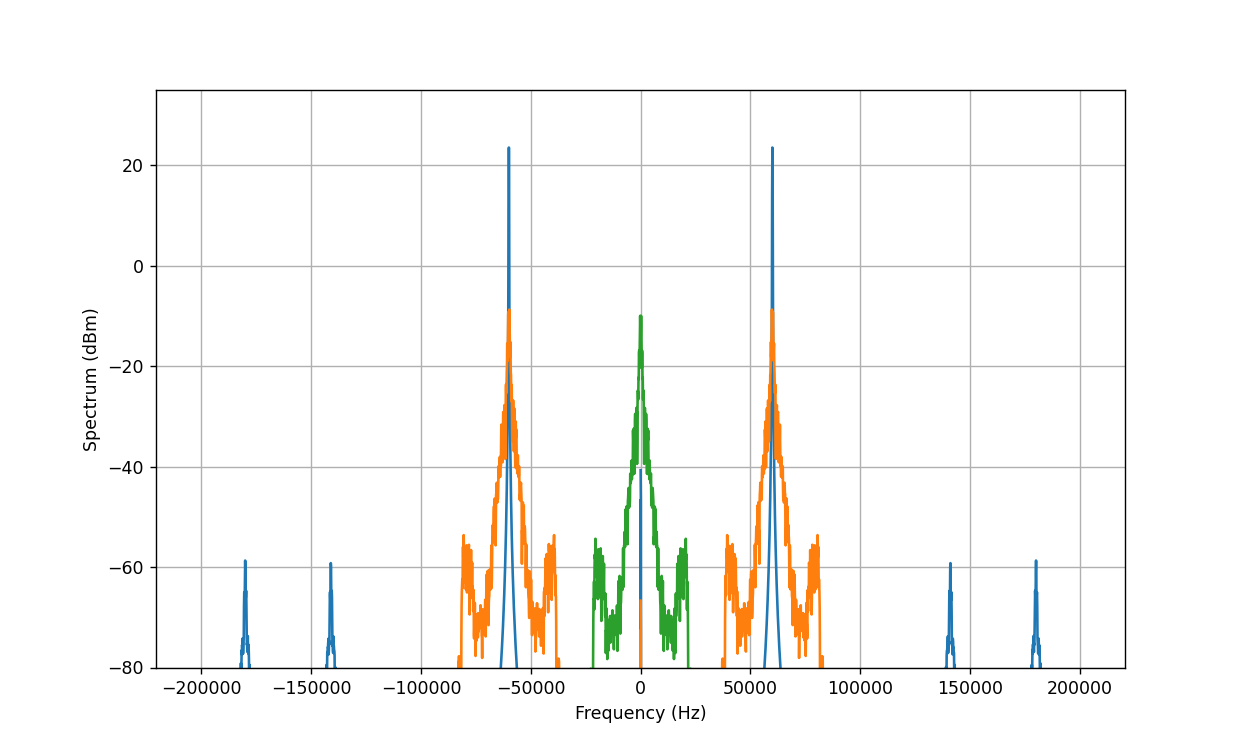

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import wave, sounddevice

from scipy.signal import welch, resample_poly, firls, lfilter

signal_frame_size = 10000  # количество отсчетов аудиофайла, получаемых за один раз
frames_number = 500        # число обрабатываемых пачек данных
rate_ratio = 10            # коэффициент увеличения частоты дискретизации
audio_amp = 2              # коэффициент усиления аудиосигнала
Fc = 60e3                  # частота несущей
freq_offset = 1000         # расстройка по частоте (Hz)

# открываем файл и получаем частоту дискретизации
signal_file = wave.open('../../wav/Audio_DSB_SC.wav')
signal_fs = signal_file.getframerate()

# частота дискретизации и размер кадра после передискретизации
audio_fs = signal_fs / rate_ratio
audio_frame_size = signal_frame_size / rate_ratio

# создаем объект PLL
am_pll = Square_signal_pll(
    sample_frequency = signal_fs,
    noise_bandwidth = 100,
    damping_factor = 0.7,
    central_frequency = Fc + freq_offset,
    signal_amp = 0.0012
    )

# получение коэффициентов ФНЧ
H = firls(175, (0, 20e3, 30e3, signal_fs/2), (1, 1, 0, 0), fs=signal_fs)

# построение осей графиков
plt.rcParams['figure.figsize'] = [10, 6]
fig,ax = plt.subplots(1,1)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Spectrum (dBm)')
ax.set_xlim(-signal_fs/2, signal_fs/2)
ax.set_ylim(-80, 35)
ax.grid(True)

# создаем линии для будущих графиков
for _ in range(3):
    ax.plot(np.arange(signal_frame_size), np.zeros(signal_frame_size))

message = []
FIR_tap_values = np.zeros(len(H) - 1) # внутреннее состояние ФНЧ

t = np.linspace(0, signal_frame_size/signal_fs, signal_frame_size) 

for frame in range(frames_number):

    # формирование отсчетов аудиосигнала
    am_signal = signal_file.readframes(signal_frame_size)      # считываем отсчеты
    am_signal = np.frombuffer(am_signal, dtype=np.int16)       # преобразуем тип данных из byte в int16
    am_signal = np.reshape(am_signal, (-1, 2))                 # разделяем отсчеты для правого и левого канала
    am_signal = am_signal[:,0] / 2**15                          # выделяем один канал и нормируем отсчеты к единице
    
    # формируем несущую c помощью PLL
    _, carrier = am_pll.step(am_signal)
    
    # смешивание АМ-сигнала и несущей
    mixed_signal = am_signal * carrier;
    
    # фильтрация сигнала
    baseband_signal, FIR_tap_values = lfilter(H, 1.0, mixed_signal, zi=FIR_tap_values)
    baseband_signal = baseband_signal - baseband_signal.mean()
    
    # построение спектрограмм
    signals = carrier, am_signal, baseband_signal
    
    for i in range(3):
        f, spectrum = welch(signals[i], signal_fs, return_onesided=False, scaling='spectrum', nperseg=4096) # вычисление спектров
        spectrum_dBm = 10*np.log10(spectrum) + 30                                                    # перевод значений в dBm
        ax.lines[i].set_xdata(f)
        ax.lines[i].set_ydata(spectrum_dBm)
    
    # уменьшение частоты дискретизации
    audio_data = resample_poly(baseband_signal, 1, rate_ratio)
    message = np.concatenate((message, audio_data))
    
    # отрисовка графиков
    fig.canvas.draw() 
    
    # обновляем отсчеты времени
    t = t + signal_frame_size/signal_fs 

sounddevice.play(message * audio_amp, audio_fs, blocking=True)



Выше представлены преобразования в частотной области. Оранжевым обозначен спектр принимаемого АМ-сигнала. Синим - спектр восстановденной несущей на выходе PLL. После переноса по частоте и фильтрации остается только информационное сообщение (зеленым).

На слух можно оценить, что при расстройке в 100 Гц демодулированный сигнал не содержит искажений. При расстройке в 1000 Гц сначала слышны сильные искажения, а потом качество сигнала исправляется. Этот временный эффект соответствует периоду вхождения PLL в режим синхронизации. Из-за большей по сравнению с предыдущем случаем расстройки по частоте длительность этого процесса увеличивается. При расстройке в 5000 Гц, слышны сильные искажения. Это происходит из-за того, что расстройка по частоте превышает полосу захвата PLL, поэтому PLL не может войти в режим синхронизации.

## 2. Когерентная демодуляция с помощью возведения сигнала в квадрат при квадратурном приеме

Рассмотрим как изменится структура когерентного демодулятора с возведением в квадрат в случае квадратурного приема. Сигнал теперь комплексный с односторонним спектром и представлен в виде:

$$s_{\textrm{am}} \left(t\right)=m\left(t\right)\cdot e^{j\cdot 2\pi f_c t},$$

где $m\left(t\right)$ - информационное сообщение, $f_c$ - частота несущей. После возведения в квадрат получим:

$$s_{\textrm{square}} \left(t\right)=m^2 \left(t\right)\cdot e^{j\cdot 2\pi \cdot 2f_c \cdot t}.$$

Таким образом, получаем комплексное гармоническое колебание, амплитуда которого не изменяет знак. Этот сигнал можно подавать на вход обычной PLL. То есть, в случае квадатурного приема схема демодулятора будет иметь тот же самый выд, что и для действительного сигнала, за исключением того, что теперь после возведения в квадрат не нужно выполнять фильтрацию.

Для реализации всех рассмотренных выше преобразований был создан класс Square_complex_pll, описывающий работу PLL с возведением сигнала в квадрат. Обработка одной пачки отсчетов сигнала запускается с помощью метода step, который возвращает значения частотной расстройки и отсчеты восстановленной несущей.

In [3]:
%matplotlib notebook
%reset -f

import numpy as np
from scipy.signal import firls, lfilter

class Square_complex_pll:
    
    def __init__(self, 
                 sample_frequency,   # sample frequency in herz
                 noise_bandwidth,    # noise bandwidth in herz
                 damping_factor,     # damping factor
                 central_frequency): # central NCO frequency in herz
        
        self.central_frequency = central_frequency
        self.sample_frequency = sample_frequency
        
        self.ts = 1/self.sample_frequency  # sample time
        BL_n = noise_bandwidth * self.ts   # normalized noise bandwidth
        
        ksi = damping_factor
        
        self.kp = 4*ksi*BL_n / (ksi + 0.25/ksi) 
        self.ki = 4*BL_n**2 / (ksi + 0.25/ksi)**2

        # PLL internal variables
        self.NCO_phase = 0
        self.loop_filter_acc = 0
        
    def step(self, input_frame):
        frame_size = input_frame.size
            
        output_frame = np.zeros(frame_size, dtype=complex)
        frequency_error = np.zeros(frame_size)
        
        # возвдение в квадрат и фольтрация входных отсчетов
        input_frame = input_frame ** 2
        
        for n in range(frame_size):
            # умножение сигнала на сигнал от NCO
            phase_error = np.angle( input_frame[n] * np.exp(-1j * self.NCO_phase) )
            
            # петлевой фильтр
            kp_out = self.kp * phase_error
            ki_out = self.ki * phase_error + self.loop_filter_acc
            loop_filter_out = kp_out + ki_out

            # обновление состояния накопителя в петлевом фильтре
            self.loop_filter_acc = ki_out;

            # обновление фазы NCO
            self.NCO_phase = self.NCO_phase + loop_filter_out + 2*np.pi*(2*self.central_frequency)*self.ts

            # формирование выходных значений
            frequency_error[n] = loop_filter_out / (2*np.pi) * self.sample_frequency 
            output_frame[n] = np.exp(1j * self.NCO_phase / 2)
            
        return frequency_error, output_frame 

Ниже представлен скрипт, выполняющий Ниже представлен скрипт, выполняющий когерентный прием сигнала с подавленной несущей. С помощью переменной freq_offset можно изменять расстройку между частотой несущей и начальной частотой управляемого генератора.

<IPython.core.display.Javascript object>


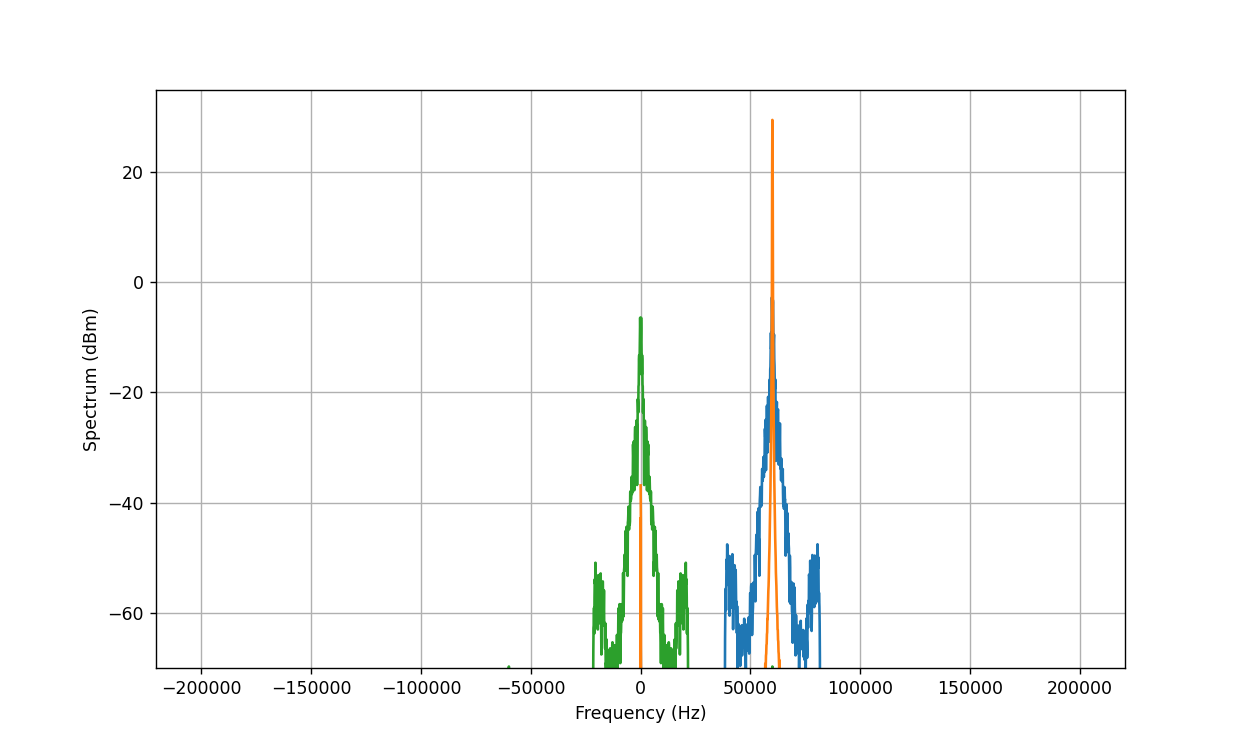

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import wave, sounddevice

from scipy.signal import welch, resample_poly

signal_frame_size = 10000  # количество отсчетов аудиофайла, получаемых за один раз
frames_number = 500        # число обрабатываемых пачек данных
rate_ratio = 10            # коэффициент увеличения частоты дискретизации
audio_amp = 2              # коэффициент усиления аудиосигнала
Fc = 60e3                  # частота несущей

freq_offset = 1000               # расстройка по частоте (Hz)

# открываем файл и получаем частоту дискретизации
signal_file = wave.open('../../wav/Audio_DSB_SC.wav')
signal_fs = signal_file.getframerate()

# частота дискретизации и размер кадра после передискретизации
audio_fs = signal_fs / rate_ratio
audio_frame_size = signal_frame_size / rate_ratio

# создаем объект PLL
am_pll = Square_complex_pll(
    sample_frequency = signal_fs,
    noise_bandwidth = 100,
    damping_factor = 0.7,
    central_frequency = Fc + freq_offset
    )

# построение осей графиков
plt.rcParams['figure.figsize'] = [10, 6]
fig,ax = plt.subplots(1,1)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Spectrum (dBm)')
ax.set_xlim(-signal_fs/2, signal_fs/2)
ax.set_ylim(-70, 35)
ax.grid(True)

# создаем линии для будущих графиков
for _ in range(3):
    ax.plot(np.arange(signal_frame_size), np.zeros(signal_frame_size))

message = []

t = np.linspace(0, signal_frame_size/signal_fs, signal_frame_size) 

for frame in range(frames_number):

    # формирование отсчетов аудиосигнала
    am_signal = signal_file.readframes(signal_frame_size)      # считываем отсчеты
    am_signal = np.frombuffer(am_signal, dtype=np.int16)       # преобразуем тип данных из byte в int16
    am_signal = np.reshape(am_signal, (-1, 2))                 # разделяем отсчеты для правого и левого канала
    am_signal = (am_signal[:,0] + 1j*am_signal[:,1]) / 2**15   # выделяем комплексный сигнал и нормируем отсчеты к единице
    
    # формируем несущую c помощью PLL
    _, carrier = am_pll.step(am_signal)
    
    # смешивание АМ-сигнала и несущей и выделение действительной части
    baseband_signal = np.real(am_signal * np.conj(carrier))
    baseband_signal = baseband_signal - baseband_signal.mean()
    
    # построение спектрограмм
    signals = am_signal, carrier, baseband_signal
    
    for i in range(3):
        f, spectrum = welch(signals[i], signal_fs, return_onesided=False, scaling='spectrum', nperseg=4096) # вычисление спектров
        spectrum_dBm = 10*np.log10(spectrum) + 30                                                    # перевод значений в dBm
        ax.lines[i].set_xdata(f)
        ax.lines[i].set_ydata(spectrum_dBm)
    
    # уменьшение частоты дискретизации
    audio_data = resample_poly(baseband_signal, 1, rate_ratio)
    message = np.concatenate((message, audio_data))
    
    # отрисовка графиков
    fig.canvas.draw() 
    
    # обновляем отсчеты времени
    t = t + signal_frame_size/signal_fs 

sounddevice.play(message * audio_amp, audio_fs, blocking=True)

Выше представлены преобразования в частотной области. Синим обозначен спектр принимаемого АМ-сигнала. Так как прием квадратурный, спектр сигнала комплексный и расположен только в положительной области частот. Оранжевым цветом представлен сигнал на выходе NCO PLL, а зеленым - сигнал на выходе смесителя. 

При прослушавании принятого сигнала при разных значениях расстройки по частоте получаем те же самые искажения, что и для действительного случая. При расстройке по частоте в 5000 Гц сигнал на выходе NCO содержит множество гармоник и не является комплексной экспонентой. Это означает, что PLL не находится в режиме синхронизации.

## Литература:
- B. P. Lathi Modern Digital and Analog Communication Systems 
- R. Stewart, K. Barlee, D. Atkinson, L. Crockett Software Defined Radio using MATLAB® & Simulink and the RTL-SDR
- F. Gardner Phaselock Techniques
- M. Rice Digital Communications. A Discrete Time Approach